In [1]:
import torch
import torch.utils.data
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 152525
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)



In [3]:
train_loader = torch.utils.data.DataLoader(
                        torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
                        batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                        torchvision.datasets.MNIST('/files/', train=False, download=True,
                                                     transform=torchvision.transforms.Compose([
                                                       torchvision.transforms.ToTensor(),
                                                       torchvision.transforms.Normalize(
                                                         (0.1307,), (0.3081,))
                                                     ])),
                        batch_size=batch_size_test, shuffle=False)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

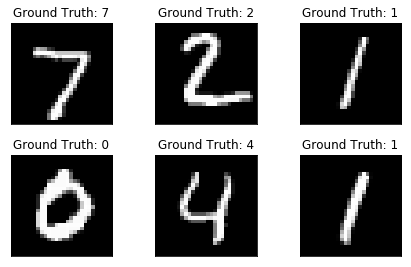

In [ ]:

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5,padding=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3,padding=2)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=3,padding=2)
        self.conv_drop = nn.Dropout2d(.2)
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv_drop(self.conv3(x)), 2))
        x = Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,-1)
    

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []

In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
        if batch_idx%(2*log_interval)==0:
            test()
            test_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))

        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
#         torch.save(network.state_dict(), '/results/model.pth')
#         torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [ ]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    test_counter.append(epoch*len(train_loader.dataset))


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.347402

Test set: Avg. loss: 2.3053, Accuracy: 1094/10000 (10%)

Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.268615
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.458369

Test set: Avg. loss: 1.4066, Accuracy: 5435/10000 (54%)

Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.848880
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.691409

Test set: Avg. loss: 0.5381, Accuracy: 8215/10000 (82%)

Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.299504
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.116703

Test set: Avg. loss: 0.2605, Accuracy: 9183/10000 (91%)

Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.232518
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.118454

Test set: Avg. loss: 0.2142, Accuracy: 9301/10000 (93%)

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.196616

Test set: Avg. loss: 0.1583, Accuracy: 9495/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.336206

Test set: Avg. loss: 0.1960, Accuracy: 9407/10000 (94%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.164170
Train 

In [ ]:
fig = plt.figure()
plt.plot(train_counter,train_losses, color='blue')
plt.plot(test_counter,test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [ ]:
with torch.no_grad():
    output = network(example_data)

In [ ]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()